# Discovering Accounts to Follow Using Graph Mining

Lots of things can be represented as graphs. This is particularly true in this day of Big Data, online social networks, and the Internet of Things. In particular, online social networks are big business, with sites such as Facebook that have over 500 million active users (50 percent of them log in each day). These sites often monetize themselves by targeted advertising. However, for users to be engaged with a website, they often need to follow interesting people or pages.

In this chapter, we will look at the concept of similarity and how we can create graphs based on it. We will also see how to split this graph up into meaningful subgraphs using connected components. This simple algorithm introduces the concept of cluster analysis—splitting a dataset into subsets based on similarity. We will investigate cluster analysis in more depth in Chapter 10, Clustering News Articles.

The topics covered in this chapter include:
- Creating graphs from social networks
- Loading and saving built classifiers
- The NetworkX package
- Converting graphs to matrices
- Distance and similarity
- Optimizing parameters based on scoring functions
- Loss functions and scoring functions

## Creating a graph & building the network
Our task is to recommend users on online social networks based on shared connections. Our logic is that if two users have the same friends, they are highly similar and worth recommending to each other.

We are going to create a small social graph from fake Twitter users. The data we are looking for is a subset of users interested in a similar topic (again, the Python programming language) and a list of all of their friends (people they follow). With this data, we will check how similar two users are, based on how many friends they have in common.

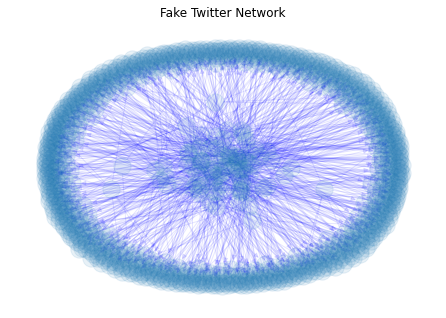

Number of nodes: 1050
Number of edges: 950
Average degree: {5: 1.0, 1: 0.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0}


In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create empty graph
G = nx.DiGraph()

# Function to add nodes with followers
def add_user(G, num_followers):
    user_id = len(G.nodes())
    G.add_node(user_id, name=f"User {user_id}")
    
    # Add followers
    for _ in range(num_followers):
        follower_id = len(G.nodes())
        G.add_node(follower_id, name=f"User {follower_id}")
        G.add_edge(user_id, follower_id)

# Generate graph with ~100 users and ~500 edges
for i in range(100):  
    add_user(G, 5 + (i % 10))  # Vary number of followers per user

# Set up edge attributes
for u, v in G.edges():
    G[u][v]['weight'] = 1

# Visualize graph
pos = nx.spring_layout(G)
nx.draw(G, alpha=0.1, edge_color='b')

plt.title("Fake Twitter Network")
plt.axis('off')
plt.show()

# Print graph stats
print(f"Number of nodes: {len(G.nodes())}")
print(f"Number of edges: {len(G.edges())}")
print(f"Average degree: {nx.average_degree_connectivity(G)}")


## Creating a similarity graph

Our task is recommendation through shared friends. As mentioned previously, our logic is that, if two users have the same friends, they are highly similar. We could recommend one user to the other on this basis.

We are therefore going to take our existing graph (which has edges relating to friendship) and create a new graph. The nodes are still users, but the edges are going to be weighted edges. A weighted edge is simply an edge with a weight property. The logic is that a higher weight indicates more similarity between the two nodes
than a lower weight. This is context-dependent. If the weights represent distance, then the lower weights indicate more similarity.

For our application, the weight will be the similarity of the two users connected by that edge (based on the number of friends they share). This graph also has the property that it is not directed. This is due to our similarity computation, where the similarity of user A to user B is the same as the similarity of user B to user A.

There are many ways to compute the similarity between two lists like this. For example, we could compute the number of friends the two have in common. However, this measure is always going to be higher for people with more friends. Instead, we can normalize it by dividing by the total number of distinct friends the two have. This is called the **Jaccard Similarity**.

The Jaccard Similarity, always between 0 and 1, represents the percentage overlap of the two. Normalization is an important part of data mining exercises and generally a good thing to do (unless you have a specific reason not to). To compute this Jaccard similarity, we divide the intersection of the two sets of followers by the union of the two. These are set operations and we have lists, so we will need to convert the friends lists to sets first.

In [2]:
friends = {}
for v in G.adjacency():
    user = v[0]
    friend_list = v[1].keys()
    friends[user] = friend_list

In [3]:
def compute_similarity(friends1, friends2):
    if len(friends1 | friends2) == 0:
        return 0
    return len(friends1 & friends2) / len(friends1 | friends2)

def create_graph(friends, threshold=0):
    G = nx.Graph()
    for user1 in friends.keys():
        for user2 in friends.keys():
            if user1 == user2:
                continue
            weight = compute_similarity(friends[user1], friends[user2])
            if weight >= threshold:
                G.add_node(user1)
                G.add_node(user2)
                G.add_edge(user1, user2, weight=weight)
    return G

G = create_graph(friends)

Number of nodes: 1050
Number of edges: 550725
Average degree: {1049: 1049.0}


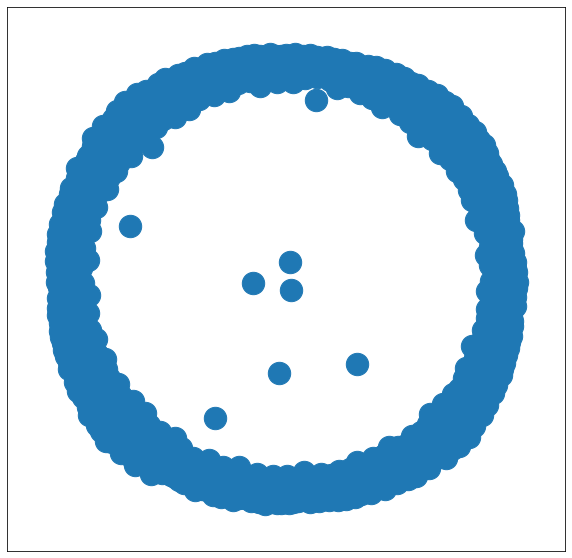

In [4]:

%matplotlib inline
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=500)

edgewidth = [d['weight'] for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edgewidth)

# Print graph stats
print(f"Number of nodes: {len(G.nodes())}")
print(f"Number of edges: {len(G.edges())}")
print(f"Average degree: {nx.average_degree_connectivity(G)}")

The difference in this graph compared to the previous graph is that the edges determine the similarity between the nodes based on our similarity metric and not on whether one is a friend of another (although there are similarities between the two!). We can now start extracting information from this graph in order to make our recommendations.

## Finding subgraphs
From our similarity function, we could simply rank the results for each user,
returning the most similar user as a recommendation—as we did with our
product recommendations. Instead, we might want to find clusters of users that
are all similar to each other. We could advise these users to start a group, create
advertising targeting this segment, or even just use those clusters to do the
recommendations themselves.

Finding these clusters of similar users is a task called cluster analysis. It is a difficult
task, with complications that classification tasks do not typically have. For example,
evaluating classification results is relatively easy—we compare our results to the
ground truth (from our training set) and see what percentage we got right. With
cluster analysis, though, there isn't typically a ground truth. Evaluation usually
comes down to seeing if the clusters make sense, based on some preconceived notion
we have of what the cluster should look like. Another complication with cluster
analysis is that the model can't be trained against the expected result to learn—it has
to use some approximation based on a mathematical model of a cluster, not what the
user is hoping to achieve from the analysis.

## Connected components
One of the simplest methods for clustering is to find the connected components in
a graph. A connected component is a set of nodes in a graph that are connected via
edges. Not all nodes need to be connected to each other to be a connected component.
However, for two nodes to be in the same connected component, there needs to be a
way to travel from one node to another in that connected component.

NetworkX has a function for computing connected components that we can
call on our graph. First, we create a new graph using our create_graph function,
but this time we pass a threshold of 0.1 to get only those edges that have a weight
of at least 0.1.